In [1]:
#######################################################################################
# Read Me Section:
## Name:
# Kaylen Smith Darnbrook
# Student ID:
# 2135667
# Course:
# M.S.c Machine Learning and Artificial Intelligence
# Module:
## FaceGeneration and Analysis:
## Description: 
# This module is responsible for creating the experimentation and creation of
# pipeline for the generation of faces using the Generative Accumulation Of Photons.
# The module will also be responsible for the analysis of the faces generated.
#####################################################################################

In [70]:
# Import Relevant Libraries:

# Import modules for system managment, io and file management 
import os 
import sys
import time 
import random

# Import modules for data manipulation and analysis
import numpy as np
import pandas as pd
import scipy as sp

# Import modules for data visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm
import matplotlib.colors as colors
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("notebook")
import plotly.express as px
from PIL import Image
import cv2
from albumentations.core.transforms_interface import ImageOnlyTransform

# Import modules for Deep learning
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
import torchsummary
torch.set_float32_matmul_precision('medium')
from torchviz import make_dot
from tqdm import tqdm

# Pytorch Lightning Modules:
import pytorch_lightning as pL
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

# Import modules for model selection and evaluation.
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

In [3]:
plt.rcParams["axes.facecolor"] = "white"
plt.rcParams["savefig.facecolor"] = "red"
plt.rc("text", usetex = False)
plt.rc("font", family = "Times New Roman")

In [4]:
## Configuration
# Set the seed for reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Set the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
GREYSCALE = True

# Set the path to the data
root_path = r"C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\ffhq256"

Batch_Size = 64
load_pretained = False
NUM_Features = 128 * 128
EPOCHS = 100
learning_rate = 0.001
patience = 10

Device: cuda


In [5]:
def PSNR(original, transformed, maximum):
    mse = np.mean((original-transformed)**2)
    if mse == 0:
        return 100
    max_pixel_value = maximum
    psnr = 20 * np.log10(max_pixel_value/np.sqrt(mse))
    return psnr

def SSIM(original, transformed):
    return sp.signal.ssim(original, transformed, multichannel=True)

def Psuedo_PSNR(original, transformed, image_size, maximum):
    mse = np.mean((original-transformed)**2)
    intensity = transformed/image_size
    if intensity == 0 or mse == 0:
        return 100
    max_pixel = maximum
    signal_score = intensity * image_size * original
    psnr = 20 * np.log(signal_score/np.sqrt(mse))
    return psnr

def Estimated_Psuedo_PSNR(transformed, image_size):
    intensity = transformed/image_size
    return 10 * np.log(intensity)

In [6]:
def plot_random_person(images, sample = 9):
    random_image_indexes=random.sample(list(range(images.shape[0])),sample)
    
    if (np.sqrt(sample) - int(np.sqrt(sample))) == 0:
        sqrt = int(np.sqrt(sample))
        Length, width = sqrt, sqrt
    else:
        Length, width = 1, sample
    
    fig = plt.figure(figsize=(20,20))
    for index, values in enumerate(random_image_indexes):
        plt.subplot(Length,width,index+1)
        plt.imshow(images[values])
        plt.title(f'Person_id: {random_image_indexes[index]}\nShape: {images.shape}')
    return fig

In [7]:
class ToGrayScale(object):
    def __call__(self, img):
        img = Image.fromarray(img.type(torch.unit8)).convert("L")
        return torch.FloatTensor(img, dtype = "float32")
    
class AddPoissonNoise(object):
    def __init__(self, psnr, amplification_factor = 1000):
        super(AddPoissonNoise, self).__init__()
        self.psnr_level = psnr
        self.amplification_factor = amplification_factor 
    def __call__(self, img):
        level = 10 ** (self.psnr_level/10.0)
        amplified_image = self.amplification_factor * img
        Poisson_Image = torch.poisson((amplified_image/amplified_image.mean()) * level)
        return Poisson_Image.type(torch.float32)
    
def get_transform():
    return transforms.Compose([
    transforms.PILToTensor(),
    transforms.CenterCrop((200,200)),
    transforms.Resize((128,128)),
    ])

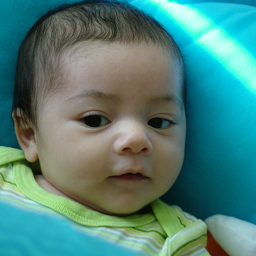

In [8]:
Image_Paths = [os.path.join(root_path, img) for img in os.listdir(root_path)]
Image_Paths 
Image.open(os.path.join(root_path, Image_Paths[0]))

In [41]:
class Image_Dataset:
    """"A blueprint responsible for creating the interface for downloading and converting the images into tensors"""
    def __init__(self, root_dir, names, targets, transform, amplification_factor = 1.0):
        self.root_dir = root_dir
        self.names = names
        self.amplification_factor = amplification_factor
        self.Transformer = transform
        self.Targets = targets
        self.Image_Paths = [os.path.join(root_dir, img) for img in self.names]

    def GeneratePoissonImage(self, img, psnr, amplification_factor):
        """A method to generate the Poisson Image"""
        level = 10 ** (psnr/10.0)
        amplified_image = amplification_factor * img
        Poisson_Image = torch.poisson((amplified_image/amplified_image.mean()) * level)
        return Poisson_Image.type(torch.float32)
        
    def __len__(self):
        """"Returns the length of the dataset"""
        return len(self.Image_Paths)
    
    def __PsnrScore__(self, index):
        return self.Targets[index]
    
    def __getitem__(self, index):
        
        image = Image.open(self.Image_Paths[index])
        psnr = self.Targets[index]
    
        image = image.convert("L")
            
        image = self.Transformer(image)
        Poisson_Image = self.GeneratePoissonImage(image, psnr, self.amplification_factor)
        
        return Poisson_Image, psnr
    
    def show_image(self, index):
        """A method to display the image at the specified index"""
        img = Image.open(self.Image_Paths[index])
        plt.imshow(img)
        plt.xlabel("X_Axis")
        plt.ylabel("Y_Axis")
        plt.show()
        
    def show_transformed_image(self, index):
        """A method to display the transformed image at the specified index"""
        image = Image.open(self.Image_Paths[index])
        psnr = self.Targets[index]
    
        image = image.convert('L')

        image = self.Transformer(image)
        Poisson_Image = self.GeneratePoissonImage(image, psnr, self.amplification_factor)

        plt.imshow(Poisson_Image.permute(1, 2, 0), cmap = "gray")
        plt.xlabel("X_Axis")
        plt.ylabel("Y_Axis")
        plt.show()
        
def Target_Generator(min_psnr, max_psnr, size, seed = seed):
    random.seed(seed)
    return torch.FloatTensor(size).uniform_(min_psnr, max_psnr).reshape(-1,1)

transformer = get_transform()
Targets = Target_Generator(-40, 30, 70000)
Targets.shape

torch.Size([70000, 1])

In [42]:
Targets_2 = Target_Generator(-40,30,70000, 30)
Targets_2.shape

torch.Size([70000, 1])

In [44]:
Directory = [path for path in os.listdir(root_path)]
rng = np.random.default_rng(20)
indices = rng.permutation(len(Directory))
split_index = int(len(Directory) * 0.8)
train_indices = indices[:split_index]
val_indices = indices[split_index:]
train_indices.shape, val_indices.shape

((56000,), (14000,))

In [45]:
Train_Paths = [Directory[index] for index in train_indices]
Val_Paths = [Directory[index] for index in val_indices]
Train_Targets = Targets[train_indices]
Valid_Targets = Targets[val_indices]
np.shape(Train_Paths), Train_Targets.shape

((56000,), torch.Size([56000, 1]))

In [51]:
Train_Dataset = Image_Dataset(root_path, Train_Paths, Train_Targets, transformer)
Valid_Dataset = Image_Dataset(root_path, Val_Paths, Valid_Targets, transformer)
Test_Dataset = Image_Dataset(root_path, Image_Paths, Targets_2, transformer)
TrainLoader = DataLoader(Train_Dataset, batch_size = Batch_Size, shuffle = True)
ValidLoader = DataLoader(Valid_Dataset, batch_size = Batch_Size, shuffle = False)
TestLoader = DataLoader(Test_Dataset, batch_size = Batch_Size, shuffle = False)
Train_Dataset.__len__(), Valid_Dataset.__len__(), Test_Dataset.__len__()

(56000, 14000, 70000)

In [47]:
iter(TrainLoader)

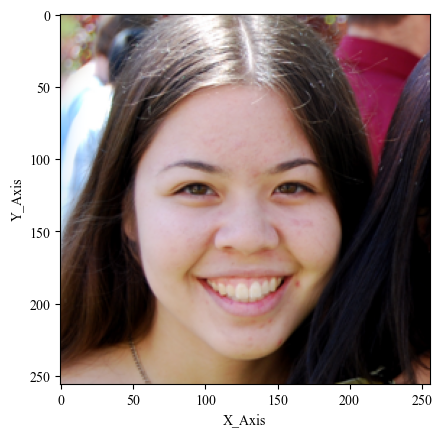

In [52]:
# Presents the untransformed image:
Train_Dataset.show_image(40)

In [15]:
Train_Dataset.__getitem__(40)

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([-17.3479]))

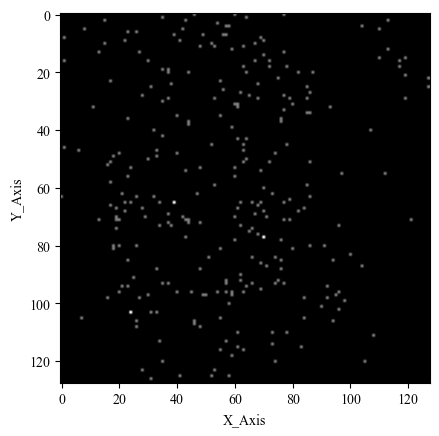

tensor([-17.3479])


In [16]:
#Presents the transformed image:
Train_Dataset.show_transformed_image(40)
print(Train_Dataset.__PsnrScore__(40))

In [17]:
# Define the Metrics to keep track of during training:

class RootMeanSquaredError:
    def __init__(self):
        self.sum_squared_error = 0.0
        self.num_examples = 0
        self.reset()
    
    def reset(self):
        self.sum_squared_error = 0.0
        self.num_examples = 0
    
    def update(self, Target, Predicted):
        squared_error = (Predicted-Target)**2
        self.sum_squared_error += squared_error.sum().item()
        self.num_examples += Target.shape[0]
    
    def compute(self):
        if self.num_examples == 0:
            return torch.tensor(0.0)
        return torch.sqrt(torch.tensor(self.sum_squared_error / self.num_examples))
    
class MeanAbsoluteError:
    def __init__(self):
        self.sum_absolute_error = 0.0
        self.num_examples = 0
        self.reset()
    
    def reset(self):
        self.sum_absolute_error = 0.0
        self.num_examples = 0
    
    def update(self, Target, Predicted):
        absolute_error = torch.abs(Predicted-Target)
        self.sum_absolute_error += absolute_error.sum().item()
        self.num_examples+= Target.shape[0]    
    def compute(self):
        if self.num_examples == 0:
            return torch.tensor(0.0)
        return torch.tensor(self.sum_absolute_error / self.num_examples)
    
class R2_Score:
    def __init__(self):
        self.sum_squared_residuals = 0.0
        self.sum_squared_totals = 0.0
        self.mean_targets = 0.0
        self.num_examples = 0
        self.reset()
    
    def reset(self):
        self.sum_squared_residuals = 0.0
        self.sum_squared_totals = 0.0
        self.mean_targets = 0.0
        self.num_examples = 0
    
    def update(self, Target, Predicted):
        self.mean_targets = Target.mean()
        self.sum_squared_residuals += ((Target - Predicted)**2).sum().item()
        self.sum_squared_totals += ((Target - self.mean_targets)**2).sum().item()
        self.num_examples += Target.shape[0]
    
    def compute(self):
        if self.num_examples == 0:
            return torch.tensor(0.0)
        return 1 - (self.sum_squared_residuals/ self.sum_squared_totals)

In [18]:
class SEblock(nn.Module):
    def __init__(self, units, bottlenecks, dropout_rate):
        super(SEblock, self).__init__()
        
        self.units = units
        self.bottlenecks = bottlenecks
        self.dropout_rate = dropout_rate
        
        # Define the SE Block layers
        self.Dense = nn.LazyLinear(units)
        self.Dropout = nn.Dropout2d(dropout_rate)
        self.GlobalPool = nn.AdaptiveAvgPool2d((1,1))
        
    def forward(self, x):
        x = self.GlobalPool(x)
        x = x.view(x.size(0), -1)
        x = self.Dense(x)
        x = F.leaky_relu(x)
        x = x.view(-1, self.units, 1, 1)
        return x

class Residual_Block(nn.Module):
    def __init__(self, filters, units, dropout_rate, units_bottleneck):
        super(Residual_Block, self).__init__()
        
        self.filters = filters
        self.units = units
        self.dropout_rate = dropout_rate
        self.units_bottleneck = units_bottleneck
        
        # Define the Residual Block Layers
        
        self.Conv_1 = nn.LazyConv2d(filters, 3, padding = 1, stride = 1)
        self.Conv_2 = nn.LazyConv2d(filters, 3, padding = 1, stride = 1)
        self.Conv_Bypass = nn.LazyConv2d(filters, 1)
        
        self.Max_Pooling = nn.MaxPool2d(2)
        self.Batch_Norm_1 = nn.LazyBatchNorm2d()
        self.Batch_Norm_2 = nn.LazyBatchNorm2d()
        self.Batch_Norm_3 = nn.LazyBatchNorm2d()
        
        self.SE_Block = SEblock(units, units_bottleneck, dropout_rate)
        
    def forward(self, x):
        
        d = self.Conv_Bypass(x)
        d = self.Batch_Norm_1(d)
        
        x = self.Conv_1(x)
        x = F.leaky_relu(x)
        x = self.Batch_Norm_2(x)
        
        x = self.Conv_2(x)
        x = F.leaky_relu(x)
        x = self.Batch_Norm_3(x)
        
        y = self.SE_Block(x)
        y = x*y
        x = y + d
        
        x = F.leaky_relu(x)
        x = self.Max_Pooling(x)
        return x
        
class ResNet(pL.LightningModule):
    def __init__(self, units, dropout_rate, num_targets, learning_rate = 1e-3, 
                 weight_decay = 1e-6, patience = 10, factor = 0.5, l1_lambda = 1e-2, 
                 l2_lambda = 1e-2):
        super(ResNet, self).__init__()
        
        # Define the Hyperparameters for the Network
        self.units = units
        self.dropout_rate = dropout_rate
        self.targets = num_targets
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay 
        self.patience = patience
        self.factor = factor
        self.l2_lambda = l2_lambda
        self.l1_lambda = l1_lambda
        self.save_hyperparameters()
        
        # Define the Feature Extractor
        self.Conv_1 = nn.LazyConv2d(32, 3, padding = 1, stride = 1)
        self.Residual_Block_1 = Residual_Block(32, 32, self.dropout_rate, 4)
        self.Residual_Block_2 = Residual_Block(64, 64, self.dropout_rate, 16)
        self.Residual_Block_3 = Residual_Block(128, 128, self.dropout_rate, 32)
        self.Residual_Block_4 = Residual_Block(256, 256, self.dropout_rate, 64)
        
        # Define the Header
        self.Head_1 = nn.LazyLinear(units)
        self.Batch_Norm_1 = nn.LazyBatchNorm1d()
        self.Head_2 = nn.Dropout(dropout_rate)
        self.Head_3 = nn.LazyLinear(units)
        self.Batch_Norm_2 = nn.LazyBatchNorm1d()
        self.Head_4 = nn.Dropout(dropout_rate)
        self.Head_5 = nn.LazyLinear(num_targets)
        
        # Define the Metrics
        #self.train_rmse = RootMeanSquaredError()
        #self.train_mae = MeanAbsoluteError()
        #self.train_r2 = R2_Score()
        
        #self.val_rmse = RootMeanSquaredError()
        #self.val_mae = MeanAbsoluteError()
        #self.val_r2 = R2_Score()
        
    def forward(self, x):
        
        x = self.Conv_1(x)
        x = self.Residual_Block_1(x)
        x = self.Residual_Block_2(x)
        
        x = self.Residual_Block_3(x)
        x = self.Residual_Block_4(x)
        
        x = x.view(x.size(0), -1)
        
        x = self.Head_1(x)
        x = F.gelu(x)
        x = self.Batch_Norm_1(x)
        x = self.Head_2(x)
        
        x = self.Head_3(x)
        x = F.gelu(x)
        x = self.Batch_Norm_2(x)
        x = self.Head_4(x)
        
        out = self.Head_5(x)
        
        return out
    
    def predict(self, batch):
        x, _ = batch
        predicted = self.forward(x)
        return predicted
    
    def training_step(self, batch, idx):
        x,y = batch
        predicted = self.forward(x)
        Loss = F.mse_loss(predicted, y)
        
        L1_Loss1 = self.Head_1.weight.abs().sum()
        L1_Loss2 = self.Head_3.weight.abs().sum()
        
        L2_Loss1 = self.Head_1.weight.pow(2.0).sum()
        L2_Loss2 = self.Head_3.weight.pow(2.0).sum()
        
        Loss += (L1_Loss1 + L1_Loss2) * self.l1_lambda + (L2_Loss1 + L2_Loss2) * self.l2_lambda
        
        #self.train_rmse.update(y,predicted)
        #self.train_mae.update(y, predicted)
        #self.train_r2.update(y, predicted)
        
        self.log("Train_Loss", Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return Loss
    
    def validation_step(self, batch, idx):
        x,y = batch
        predicted = self.forward(x)
        Validation_Loss = F.mse_loss(predicted, y)
        
        L1_Loss1 = self.Head_1.weight.abs().sum()
        L1_Loss2 = self.Head_3.weight.abs().sum()
        
        L2_Loss1 = self.Head_1.weight.pow(2.0).sum()
        L2_Loss2 = self.Head_3.weight.pow(2.0).sum()
        
        Validation_Loss += (L1_Loss1 + L1_Loss2) * self.l1_lambda + (L2_Loss1 + L2_Loss2) * self.l2_lambda
        
        #self.val_rmse.update(y,predicted)
        #self.val_mae.update(y, predicted)
        #self.val_r2.update(y, predicted)
        
        self.log("Validation_Loss", Validation_Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return Validation_Loss
    
    def test_step(self, batch, idx):
        x,y = batch
        predicted = self.forward(x)
        Test_Loss = F.mse_loss(predicted, y)
        
        L1_Loss1 = self.Head_1.weight.abs().sum()
        L1_Loss2 = self.Head_3.weight.abs().sum()
        
        L2_Loss1 = self.Head_1.weight.pow(2.0).sum()
        L2_Loss2 = self.Head_3.weight.pow(2.0).sum()
        
        Test_Loss += (L1_Loss1 + L1_Loss2) * self.l1_lambda + (L2_Loss1 + L2_Loss2) * self.l2_lambda
        
        #self.val_rmse.update(y,predicted)
        #self.val_mae.update(y, predicted)
        #self.val_r2.update(y, predicted)
        
        self.log("Test_Loss", Test_Loss, on_step = True, on_epoch = True, prog_bar = True, logger = True)
        return Test_Loss
    
    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr = self.learning_rate, weight_decay=self.weight_decay)
        scheduler = {
            "scheduler":ReduceLROnPlateau(optimizer, mode = "min", factor = self.factor, patience = self.patience, verbose = True),
            "monitor":"Validation_Loss"
        }
        
        return [optimizer], [scheduler]
    
    def weights_init(self, m):
        if isinstance(m, nn.Conv2d):
            torch.nn.init.kaiming_normal_(m.weight, nonlinearity = "relu")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
        if isinstance(m, nn.LazyLinear):
            torch.nn.init.kaiming_normal_(m.weight, nonlinearity = "relu")
            if m.bias is not None:
                torch.nn.init.zeros_(m.bias)
    """         
    def on_train_epoch_end(self):
        # Compute the metrics
        rmse_result = self.train_rmse.compute()
        mae_result = self.train_mae.compute()
        r2_result = self.train_r2.compute()
        
        # Log the metrics
        #self.log("train_rmse", rmse_result, prog_bar = True, logger = True)
        #self.log("train_mae", mae_result, prog_bar = True, logger = True)
        #self.log("train_r2", r2_result, prog_bar = True, logger = True)
        
        # Reset the metrics
        self.train_rmse.reset()
        self.train_mae.reset()
        self.train_r2.reset()
        
    def on_validation_epoch_end(self):
        
        # Compute the metrics
        rmse_result = self.val_rmse.compute()
        mae_result = self.val_mae.compute()
        r2_result = self.val_r2.compute()
        
        # Log the metrics
        #self.log("val_rmse", rmse_result, prog_bar = True, logger = True)
        #self.log("val_mae", mae_result, prog_bar = True, logger = True)
        #self.log("val_r2", r2_result, prog_bar = True, logger = True)
        
        # Reset the metrics
        self.train_rmse.reset()
        self.train_mae.reset()
        self.train_r2.reset()
    """
    
Residual_ConvNet = ResNet(100,0.4,1).to(device)
torchsummary.summary(Residual_ConvNet, (1,128,128), device = device.type)

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             320
            Conv2d-2         [-1, 32, 128, 128]           1,056
       BatchNorm2d-3         [-1, 32, 128, 128]              64
            Conv2d-4         [-1, 32, 128, 128]           9,248
       BatchNorm2d-5         [-1, 32, 128, 128]              64
            Conv2d-6         [-1, 32, 128, 128]           9,248
       BatchNorm2d-7         [-1, 32, 128, 128]              64
 AdaptiveAvgPool2d-8             [-1, 32, 1, 1]               0
            Linear-9                   [-1, 32]           1,056
          SEblock-10             [-1, 32, 1, 1]               0
        MaxPool2d-11           [-1, 32, 64, 64]               0
   Residual_Block-12           [-1, 32, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]           2,112
      BatchNorm2d-14           [-1, 64,

In [19]:
# Create a dummy input tensor with the appropriate shape
dummy_input = torch.randn(32, 1, 128, 128).to(device)

# Visualize the model
model_graph = make_dot(Residual_ConvNet(dummy_input), params=dict(Residual_ConvNet.named_parameters()))
model_graph.render("ResidualConvNet_Architecture", format="png")

'ResidualConvNet_Architecture.png'

In [33]:
# Set up the training loop for the model
Early_Stopping = EarlyStopping(monitor = "Validation_Loss", patience = 5, mode = "min")
Model_Checkpoint = ModelCheckpoint(monitor = "Validation_Loss",
                                   mode = "min", 
                                   dirpath = "./models/ResNet",
                                   filename = "ResNet-{epoch:02d}-{Validation_Loss:.2f}",
                                   save_weights_only = True)
Learning_Rate_Monitor = LearningRateMonitor(logging_interval = "step")
Tensorboard_Logger = TensorBoardLogger("Lightning_logs", name = "ResNet")
Max_Epochs = 30

In [34]:
name = "Convolutional_ResNet"
CHECKPOINT_PATH = './models/'
Trainer = pL.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, name), gradient_clip_val=10,
                     max_epochs=Max_Epochs, accelerator = "gpu", logger=Tensorboard_Logger,
                     callbacks=[Model_Checkpoint,
                                Learning_Rate_Monitor,
                                Early_Stopping])

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [35]:
Trainer.fit(Residual_ConvNet, TrainLoader, ValidLoader)
Trainer.save_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt')

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:653: Checkpoint directory C:\Users\kdarn\OneDrive\Documents\Life's Portfolio\Projects\GAPGalaxies\models\ResNet exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
INFO:pytorch_lightning.callbacks.model_summary:
   | Name             | Type           | Params
-----------------------------------------------------
0  | Conv_1           | Conv2d         | 320   
1  | Residual_Block_1 | Residual_Block | 20.8 K
2  | Residual_Block_2 | Residual_Block | 62.1 K
3  | Residual_Block_3 | Residual_Block | 247 K 
4  | Residual_Block_4 | Residual_Block | 985 K 
5  | Head

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [22]:
name = "Convolutional_ResNet"
CHECKPOINT_PATH = './models/'
Model = ResNet.load_from_checkpoint(os.path.join(CHECKPOINT_PATH, name)+'.ckpt').to(device)
Model

c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


ResNet(
  (Conv_1): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (Residual_Block_1): Residual_Block(
    (Conv_1): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Conv_2): LazyConv2d(0, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (Conv_Bypass): LazyConv2d(0, 32, kernel_size=(1, 1), stride=(1, 1))
    (Max_Pooling): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Batch_Norm_1): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Batch_Norm_2): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (Batch_Norm_3): LazyBatchNorm2d(0, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (SE_Block): SEblock(
      (Dense): LazyLinear(in_features=0, out_features=32, bias=True)
      (Dropout): Dropout2d(p=0.4, inplace=False)
      (GlobalPool): AdaptiveAvgPool2d(output_size=(1, 1))
    )
  )
  (Residual_Block_2):

In [36]:
Trainer.test(Residual_ConvNet, ValidLoader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │     5.070562362670898     │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 5.070562362670898}]

In [37]:
Trainer.test(Residual_ConvNet, TrainLoader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:492: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │     5.049946308135986     │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 5.049946308135986}]

In [54]:
Trainer.test(Residual_ConvNet, TestLoader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
c:\Users\kdarn\anaconda3\envs\GAPGalaxy\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│      Test_Loss_epoch      │     5.061954498291016     │
└───────────────────────────┴───────────────────────────┘

[{'Test_Loss_epoch': 5.061954498291016}]

In [59]:
iter(TestLoader)

In [66]:
predictions = []
Model = Residual_ConvNet.to(device)
index = 0
with torch.no_grad():
    for data in TestLoader:
        images, labels = data
        images = images.to(device)
        labels = labels.to(device)

        outputs = Model(images)
        predictions.extend(outputs.cpu().numpy())
        if index % 20 == 0:
            print(f"index {index}")
        index+=1

index 0
index 20
index 40
index 60
index 80
index 100
index 120
index 140
index 160
index 180
index 200
index 220
index 240
index 260
index 280
index 300
index 320
index 340
index 360
index 380
index 400
index 420
index 440
index 460
index 480
index 500
index 520
index 540
index 560
index 580
index 600
index 620
index 640
index 660
index 680
index 700
index 720
index 740
index 760
index 780
index 800
index 820
index 840
index 860
index 880
index 900
index 920
index 940
index 960
index 980
index 1000
index 1020
index 1040
index 1060
index 1080


AttributeError: 'list' object has no attribute 'shape'

In [68]:
Predictions = np.array(predictions)
Predictions.shape

(70000, 1)

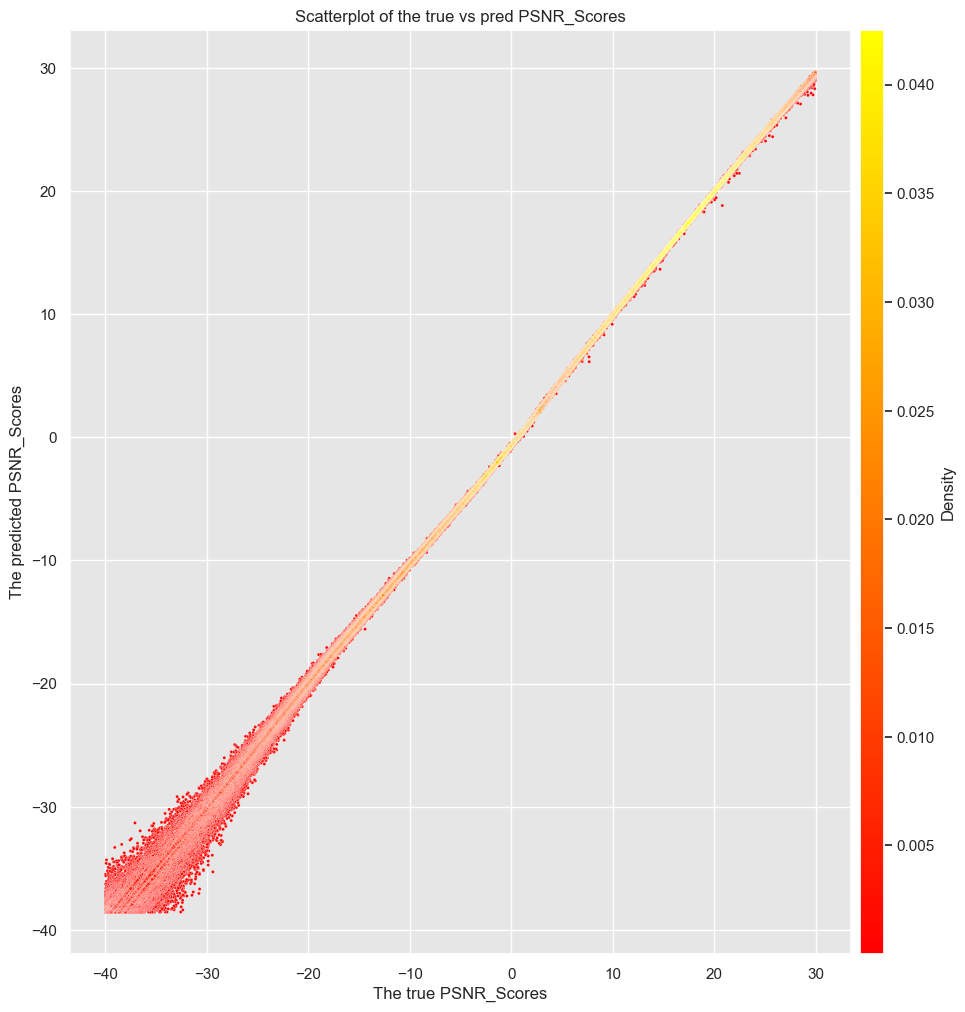

In [76]:
# Plot the Predicted Vs True values of the PSNR_Scores
fig, ax = plt.subplots(figsize = (12,12))
x = Targets_2.cpu().numpy()[:,0]
y = Predictions[:, 0]
grid = np.vstack([x, y])
z = gaussian_kde(grid)(grid)
idx = z.argsort()
x,y,z = x[idx], y[idx], z[idx]

im = sns.scatterplot(
    x = x,
    y = y,
    c = z,
    s = 5,
    cmap = "autumn",
    )
norm = plt.Normalize(z.min(), z.max())
sm = plt.cm.ScalarMappable(cmap = "autumn", norm = norm)
sm.set_array([])
im.figure.colorbar(sm, label = "Density", orientation = "vertical", pad = 0.01, aspect = 40, ax = ax)
ax.set_title("Scatterplot of the true vs pred PSNR_Scores")
ax.set_xlabel("The true PSNR_Scores")
ax.set_ylabel("The predicted PSNR_Scores")
plt.show()

In [79]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import explained_variance_score

r2 = r2_score(Targets_2.cpu().numpy(), Predictions)
mse = mean_squared_error(Targets_2.cpu().numpy(), Predictions)
mae = mean_absolute_error(Targets_2.cpu().numpy(), Predictions)
evs = explained_variance_score(Targets_2.cpu().numpy(), Predictions)

print(f"The r2_score is {r2}")
print(f"The mean_squared_error is {mse}")
print(f"The mean_absolute_error is {mae}")
print(f"The explained_variance_score is {evs}")

The r2_score is 0.9986575841903687
The mean_squared_error is 0.545066237449646
The mean_absolute_error is 0.47046539187431335
The explained_variance_score is 0.9987735748291016
